In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats
import early_warning_detection_functions
import matplotlib.pyplot as plt
import geopandas as gpd

import pymannkendall as mk

import math

from scipy.stats import friedmanchisquare


import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import statsmodels.discrete.discrete_model as dm

import statsmodels.formula.api as smf


# Read the data

In [2]:
df_aps = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_phc_only_imed.parquet')

df_otc = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_otc_only_imed.parquet')

df_aih = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_aih_imed2.parquet')



# Plots

In [3]:
dta1 = df_aps.groupby(['year_week','year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end'])[['atend_ivas', 'num_otc_ivas', 'out_of_limits_above_phc_only']].sum().reset_index()


In [4]:
dta2 =  df_otc.groupby(['year_week'])[['out_of_limits_above_otc_only']].sum().reset_index()

In [5]:
dta3 = df_aih.groupby(['year_week'])[['n','warning_final_aih']].sum().reset_index()

In [6]:
dta_br = dta1.merge(dta2, on = 'year_week', how = 'left')

In [7]:
dta_br = dta_br.merge(dta3, on = 'year_week', how = 'left')

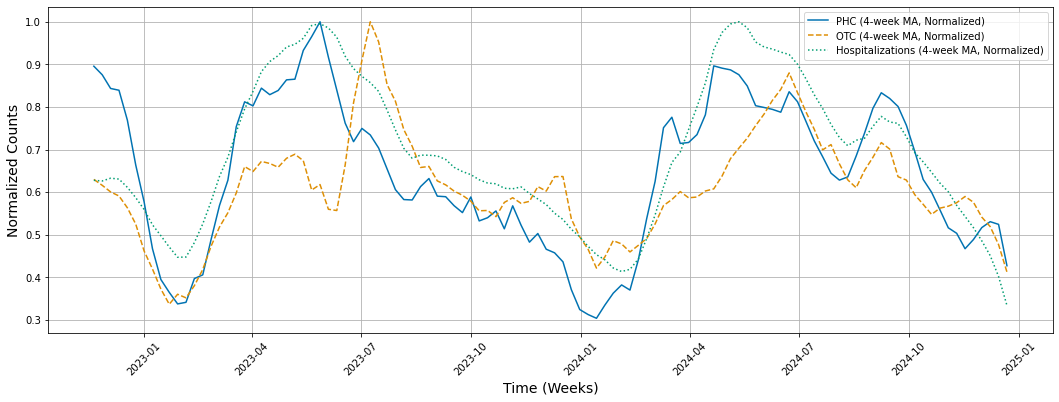

In [8]:
sns.set_palette("colorblind")

colors = sns.color_palette("colorblind", 3)  # Extract 3 colors

df = dta_br.copy()  # Make a copy to avoid modifying original data

# Convert 'epidemi_cal_start' to datetime
df['epidemi_cal_start'] = pd.to_datetime(df['epidemi_cal_start'])

# Compute 4-week moving average
df['phc_ma'] = df['atend_ivas'].rolling(window=4, min_periods=1).mean()
df['otc_ma'] = df['num_otc_ivas'].rolling(window=4, min_periods=1).mean()
df['aih_ma'] = df['n'].rolling(window=4, min_periods=1).mean()

# Normalize after smoothing
df['phc_norm'] = df['phc_ma'] / df['phc_ma'].max()
df['otc_norm'] = df['otc_ma'] / df['otc_ma'].max()
df['aih_norm'] = df['aih_ma'] / df['aih_ma'].max()

# Plotting
plt.figure(figsize=(18, 6))
plt.plot(df['epidemi_cal_start'], df['phc_norm'], label="PHC (4-week MA, Normalized)", linestyle="-", color=colors[0])
plt.plot(df['epidemi_cal_start'], df['otc_norm'], label="OTC (4-week MA, Normalized)", linestyle="--", color=colors[1])
plt.plot(df['epidemi_cal_start'], df['aih_norm'], label="Hospitalizations (4-week MA, Normalized)", linestyle=":", color=colors[2])

# Formatting
plt.xlabel("Time (Weeks)", fontsize=14)
plt.ylabel("Normalized Counts", fontsize=14)
#plt.title("4-Week Moving Average of PHC, OTC, and Hospitalizations (Normalized)", fontsize=16)
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


In [14]:
#df[['year_week', 'year_week_ts',  'phc_norm', 'otc_norm', 'aih_norm']][10:40]

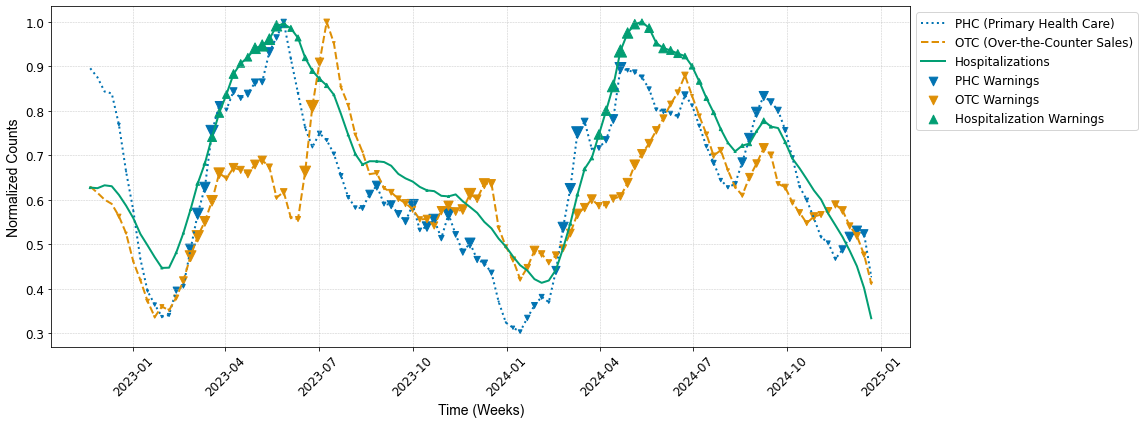

In [11]:
sns.set_palette("colorblind")

colors = sns.color_palette("colorblind", 3)  # Extract 3 colors


# Ensure 'epidemi_cal_start' is in datetime format
df['epidemi_cal_start'] = pd.to_datetime(df['epidemi_cal_start'])

# Compute normalized warning columns (scaling between 0 and 1)
df['warnings_phc_norm'] = df['out_of_limits_above_phc_only'] / df['out_of_limits_above_phc_only'].max()
df['warnings_otc_norm'] = df['out_of_limits_above_otc_only'] / df['out_of_limits_above_otc_only'].max()
df['warnings_aih_norm'] = df['warning_final_aih'] / df['warning_final_aih'].max()

# Define triangle size scaling (adjust as needed for visibility)
triangle_size_phc = df['warnings_phc_norm'] * 150  
triangle_size_otc = df['warnings_otc_norm'] * 150  
triangle_size_aih = df['warnings_aih_norm'] * 150  

# Create the figure
fig, ax = plt.subplots(figsize=(16, 6))

# Plot PHC, OTC, and AIH normalized time series
ax.plot(df['epidemi_cal_start'], df['phc_norm'], label="PHC (Primary Health Care)", linestyle=":", 
        color=colors[0], linewidth=2) #alpha=0.5

ax.plot(df['epidemi_cal_start'], df['otc_norm'], label="OTC (Over-the-Counter Sales)", linestyle="--", 
        color=colors[1], linewidth=2)

ax.plot(df['epidemi_cal_start'], df['aih_norm'], label="Hospitalizations", linestyle="-", 
        color=colors[2], linewidth=2)

# Add PHC warning triangles
ax.scatter(df['epidemi_cal_start'], df['phc_norm'], 
           marker='v', color=colors[0],s=triangle_size_phc, label="PHC Warnings")

# Add OTC warning triangles
ax.scatter(df['epidemi_cal_start'], df['otc_norm'], 
           marker='v', color=colors[1],s=triangle_size_otc, label="OTC Warnings")

# Add AIH warning triangles
ax.scatter(df['epidemi_cal_start'], df['aih_norm'], 
           marker='^', color=colors[2], s=triangle_size_aih, label="Hospitalization Warnings")

# Formatting  
ax.set_xlabel("Time (Weeks)", fontsize=14, fontname="Arial")  
ax.set_ylabel("Normalized Counts", fontsize=14, fontname="Arial")  
#ax.set_title("Time Series of PHC, OTC & Hospitalizations with Warning Indicators", fontsize=18, fontweight="bold", fontname="Arial")  

ax.tick_params(axis='both', labelsize=12)  
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  

# Rotate x-axis labels for better readability  
plt.xticks(rotation=45)  

# Move the legend outside the plot  
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))  

# Adjust layout for better spacing  
plt.tight_layout()  

# Show the plot  
plt.show()


Caption: Normalized counts of influenza-like illness hospitalizations (bold line), PHC encounters (dotted line), 
and over-the-counter drug sales (dashed line) in Brazil from November 2022 to December 2024.
Triangular markers indicate the frequency of warnings across Brazilian immediate regions derived from each series. 



# Test trend

In [12]:
dta_br = dta_br.assign(atend_ivas_4 = dta_br['atend_ivas'].rolling(window=4, min_periods=1).mean().to_numpy(),
                      epidemi_cal_start = pd.to_datetime(dta_br['epidemi_cal_start']),
                      num_otc_ivas_4 = dta_br['num_otc_ivas'].rolling(window=4, min_periods=1).mean().to_numpy(),
                      n_4 = dta_br['n'].rolling(window=4, min_periods=1).mean().to_numpy())

In [13]:
# Perform Mann-Kendall tests
resultado_serie1 = mk.original_test(dta_br['atend_ivas_4'])


In [14]:
resultado_serie1 

Mann_Kendall_Test(trend='no trend', h=False, p=0.22276568573284083, z=-1.2192068683464614, Tau=-0.07889908256880734, s=-473.0, var_s=149875.0, slope=-486.515625, intercept=487830.2265625)

In [15]:
resultado_serie2 = mk.original_test(dta_br['num_otc_ivas_4'])

In [16]:
resultado_serie2

Mann_Kendall_Test(trend='no trend', h=False, p=0.23679172855484865, z=1.183043952759914, Tau=0.07656380316930776, s=459.0, var_s=149875.0, slope=3728.2297297297296, intercept=5062064.35472973)

In [17]:
resultado_serie3 = mk.original_test(dta_br['n_4'])

In [18]:
resultado_serie3

Mann_Kendall_Test(trend='no trend', h=False, p=0.42029105175133363, z=-0.8059164045002034, Tau=-0.05221017514595496, s=-313.0, var_s=149875.0, slope=-10.946428571428571, intercept=16722.83035714286)

# Test seazonality

In [19]:
def friedman_test(x, freq=None):
    """
    Conducts a Friedman rank test for seasonality in a time series.
    
    Parameters:
    - x: pandas Series or numpy array, the time series data.
    - freq: int, the frequency of the time series.
    
    Returns:
    - dict: Contains test statistic, p-value, and additional information.
    """
    
    # Reshape into matrix form for Friedman test
    rows = len(x) // freq
    if rows < 2:
        raise ValueError("Not enough data points for the specified frequency.")
    
    x = x[:rows * freq]  # Truncate to fit matrix dimensions
    data_matrix = np.reshape(x, (rows, freq))
    
    # Perform Friedman test
    test_stat, p_value = friedmanchisquare(*data_matrix.T)
    
    # Output results
    return {
        "test_stat": test_stat,
        "p_value": p_value,
        "rows": rows,
        "columns": freq
    }


In [20]:
p = len(dta_br) // 2

res_test = friedman_test(dta_br['atend_ivas_4'].to_numpy(), freq= p)


In [21]:
res_test

{'test_stat': 78.64675324675324,
 'p_value': 0.01592775498816487,
 'rows': 2,
 'columns': 55}

In [22]:
res_test = friedman_test(dta_br['num_otc_ivas_4'].to_numpy(), freq= p)
res_test


{'test_stat': 90.87272727272727,
 'p_value': 0.0012552156130983061,
 'rows': 2,
 'columns': 55}

In [23]:
res_test = friedman_test(dta_br['n_4'].to_numpy(), freq= p)
res_test


{'test_stat': 103.7883116883117,
 'p_value': 5.463552651207272e-05,
 'rows': 2,
 'columns': 55}

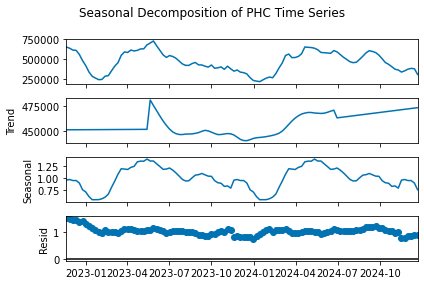

In [24]:
# Decompose the time series into trend, seasonal and residual components
result = seasonal_decompose(dta_br[['epidemi_cal_start', 'atend_ivas_4']].set_index('epidemi_cal_start'), model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle('Seasonal Decomposition of PHC Time Series')
plt.tight_layout()
plt.show()


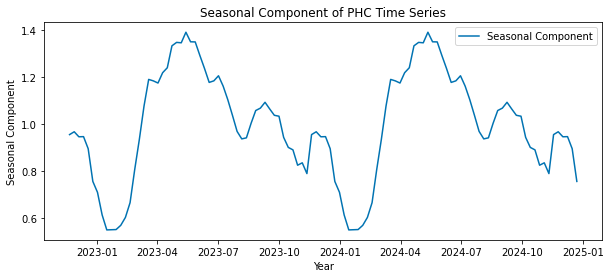

In [25]:
# Plot the seasonal component
plt.figure(figsize=(10, 4))
plt.plot(result.seasonal, label='Seasonal Component')
plt.title('Seasonal Component of PHC Time Series')
plt.xlabel('Year')
plt.ylabel('Seasonal Component')
plt.legend()
plt.show()


In [26]:
result.seasonal.describe()

count    110.000000
mean       0.995154
std        0.228515
min        0.550704
25%        0.890457
50%        0.968734
75%        1.181598
max        1.389635
Name: seasonal, dtype: float64

In [27]:
result.seasonal[result.seasonal == result.seasonal.max()]

epidemi_cal_start
2023-05-14    1.389635
2024-05-12    1.389635
Name: seasonal, dtype: float64

In [28]:
result.seasonal[result.seasonal > 0.968734].reset_index().groupby(['epidemi_cal_start'])['seasonal'].sum().reset_index()

,epidemi_cal_start,seasonal
0,2023-03-12,1.076486
1,2023-03-19,1.189464
2,2023-03-26,1.183217
3,2023-04-02,1.174082
4,2023-04-09,1.217853
5,2023-04-16,1.238929
6,2023-04-23,1.332044
7,2023-04-30,1.346559
8,2023-05-07,1.344827
9,2023-05-14,1.389635


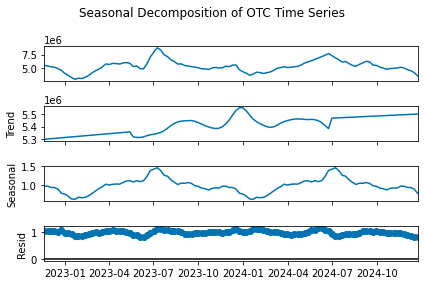

In [29]:
# Decompose the time series into trend, seasonal and residual components
result = seasonal_decompose(dta_br[['epidemi_cal_start', 'num_otc_ivas_4']].set_index('epidemi_cal_start'), model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle('Seasonal Decomposition of OTC Time Series')
plt.tight_layout()
plt.show()

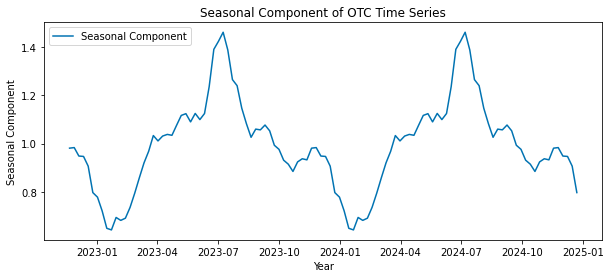

In [30]:
# Plot the seasonal component
plt.figure(figsize=(10, 4))
plt.plot(result.seasonal, label='Seasonal Component')
plt.title('Seasonal Component of OTC Time Series')
plt.xlabel('Year')
plt.ylabel('Seasonal Component')
plt.legend()
plt.show()


In [31]:
result.seasonal.describe()

count    110.000000
mean       0.996018
std        0.189294
min        0.641453
25%        0.908376
50%        0.983349
75%        1.088261
max        1.462392
Name: seasonal, dtype: float64

In [32]:
result.seasonal[result.seasonal == result.seasonal.max()]

epidemi_cal_start
2023-07-09    1.462392
2024-07-07    1.462392
Name: seasonal, dtype: float64

In [33]:
result.seasonal[result.seasonal > 0.983349].reset_index().groupby(['epidemi_cal_start'])['seasonal'].sum().reset_index()

,epidemi_cal_start,seasonal
0,2022-11-27,0.983349
1,2023-03-26,1.033391
2,2023-04-02,1.011040
3,2023-04-09,1.031253
4,2023-04-16,1.038105
5,2023-04-23,1.034403
6,2023-04-30,1.076130
7,2023-05-07,1.116938
8,2023-05-14,1.124237
9,2023-05-21,1.090103


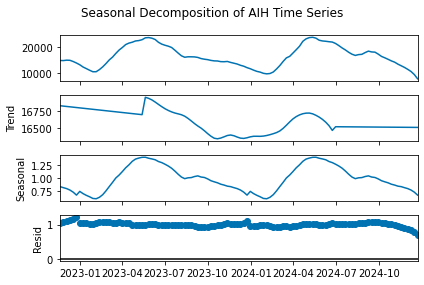

In [34]:
# Decompose the time series into trend, seasonal and residual components
result = seasonal_decompose(dta_br[['epidemi_cal_start', 'n_4']].set_index('epidemi_cal_start'), model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle('Seasonal Decomposition of AIH Time Series')
plt.tight_layout()
plt.show()

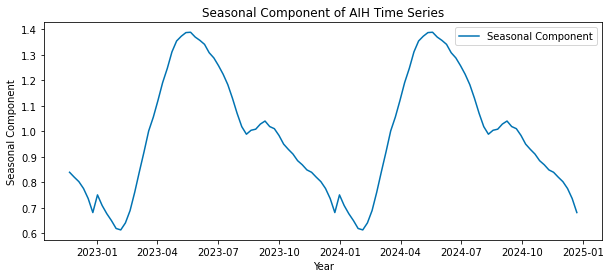

In [35]:
# Plot the seasonal component
plt.figure(figsize=(10, 4))
plt.plot(result.seasonal, label='Seasonal Component')
plt.title('Seasonal Component of AIH Time Series')
plt.xlabel('Year')
plt.ylabel('Seasonal Component')
plt.legend()
plt.show()


In [36]:
result.seasonal.describe()

count    110.000000
mean       0.987802
std        0.235839
min        0.613732
25%        0.803063
50%        0.989035
75%        1.189502
max        1.388906
Name: seasonal, dtype: float64

In [37]:
result.seasonal[result.seasonal == result.seasonal.max()]

epidemi_cal_start
2023-05-21    1.388906
2024-05-19    1.388906
Name: seasonal, dtype: float64

In [38]:
result.seasonal[result.seasonal > 0.989035].reset_index().groupby(['epidemi_cal_start'])['seasonal'].sum().reset_index()

,epidemi_cal_start,seasonal
0,2023-03-19,1.001878
1,2023-03-26,1.056222
2,2023-04-02,1.121807
3,2023-04-09,1.191494
4,2023-04-16,1.247056
5,2023-04-23,1.311897
6,2023-04-30,1.354613
7,2023-05-07,1.373211
8,2023-05-14,1.387540
9,2023-05-21,1.388906


# Peform the same analyses by region

## Read auxiliar data

In [39]:


df_imed_key = pd.read_csv('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RELATORIO_DTB_BRASIL_MUNICIPIO.csv',sep = ';')

df_pop = pd.read_csv('/Users/julianeoliveira/Documents/Projects/AESOP/AESOP datalake/Population/table_2009_2023_etcc_eq_zero.csv')


## Format data

In [40]:
df_pop = df_pop[['Cód.', 'Uf', '2022']]

df_imed_key = df_imed_key[['Nome_UF', 'UF',  'Região Geográfica Imediata',
       'Nome Região Geográfica Imediata', 
       'Município', 'Código Município Completo', 'Nome_Município']]

df_pop = df_pop.rename(columns = {'Cód.': 'co_ibge7'}) 

df_imed_key = df_imed_key.rename(columns = {'Código Município Completo': 'co_ibge7', 
                                            'Região Geográfica Imediata': 'co_imed'})

df_imed_key = df_imed_key.merge(df_pop, on='co_ibge7', how='left')

df_imed_pop = df_imed_key.groupby(['co_imed'])['2022'].sum().reset_index()

df_imed_pop = df_imed_pop.assign(pop_2022 = df_imed_pop['2022'].astype(int))
df_imed_pop = df_imed_pop[['co_imed', 'pop_2022']]


df_codes_imed = df_imed_key.groupby(['Nome_UF','UF', 'co_imed','Uf'])['2022'].sum().reset_index()

df_aih = df_aih.merge(df_codes_imed, on='co_imed', how='left')

#df_aps = df_aps.merge(df_codes_imed, on='co_imed', how='left')

#df_otc = df_otc.merge(df_codes_imed, on='co_imed', how='left')

In [41]:
# Dictionary mapping Brazilian states to their regions
state_to_region = {
    "AC": "North", "AM": "North", "AP": "North", "PA": "North", "RO": "North", "RR": "North", "TO": "North",
    "AL": "Northeast", "BA": "Northeast", "CE": "Northeast", "MA": "Northeast", "PB": "Northeast",
    "PE": "Northeast", "PI": "Northeast", "RN": "Northeast", "SE": "Northeast",
    "DF": "Center-West", "GO": "Center-West", "MT": "Center-West", "MS": "Center-West",
    "ES": "Southeast", "MG": "Southeast", "RJ": "Southeast", "SP": "Southeast",
    "PR": "South", "RS": "South", "SC": "South"
}

# Dictionary mapping Brazilian states to their regions
state_to_region2 = {
    "Acre": "North", "Amazonas": "North", "Amapá": "North", "Pará": "North", "Rondônia": "North", "Roraima": "North", "Tocantins": "North",
    "Alagoas": "Northeast", "Bahia": "Northeast", "Ceará": "Northeast", "Maranhão": "Northeast", "Paraíba": "Northeast",
    "Pernambuco": "Northeast", "Piauí": "Northeast", "Rio Grande do Norte": "Northeast", "Sergipe": "Northeast",
    "Distrito Federal": "Center-West", "Goiás": "Center-West", "Mato Grosso": "Center-West", "Mato Grosso do Sul": "Center-West",
    "Espírito Santo": "Southeast", "Minas Gerais": "Southeast", "Rio de Janeiro": "Southeast", "São Paulo": "Southeast",
    "Paraná": "South", "Rio Grande do Sul": "South", "Santa Catarina": "South"
}




# Create a new column 'region' by mapping state codes to regions


df_aih["region"] = df_aih["Uf"].map(state_to_region)

df_pop["region"] = df_pop["Uf"].map(state_to_region)

df_codes_imed["region"] = df_codes_imed["Uf"].map(state_to_region)

In [42]:
df_aps["region"] = df_aps["nm_uf"].map(state_to_region2)

df_otc["region"] = df_otc["nm_uf"].map(state_to_region2)

In [43]:
df_aps = df_aps.assign(atend_ivas = df_aps.atend_ivas.astype(int),
                       num_otc_ivas = df_aps.num_otc_ivas.astype(int),
                       out_of_limits_above_phc_only = df_aps.out_of_limits_above_phc_only .astype(int))

dta1 = df_aps.groupby(['region','year_week','year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end'])[['atend_ivas', 'num_otc_ivas', 'out_of_limits_above_phc_only']].sum().reset_index()


In [44]:
dta1 = dta1.assign(year_week = dta1.year_week.astype(str))

In [45]:
dta2 =  df_otc.groupby(['region','year_week'])[['out_of_limits_above_otc_only']].sum().reset_index()
dta2 = dta2.assign(year_week = dta2.year_week.astype(str))

In [46]:
dta3 = df_aih.groupby(['region','year_week'])[['n','warning_final_aih']].sum().reset_index()
dta3 = dta3.assign(year_week = dta3.year_week.astype(str))

In [47]:
dta_br = dta1.merge(dta2, on = ['region','year_week'], how = 'left')

In [48]:
dta_br = dta_br.merge(dta3, on = ['region','year_week'], how = 'left')

In [49]:
dta_br = dta_br[['year_week', 'year_week_ts', 'epidemi_cal_start',
       'epidemi_cal_end', 'atend_ivas', 'num_otc_ivas',
       'out_of_limits_above_phc_only',
       'out_of_limits_above_otc_only', 'region', 'n', 'warning_final_aih']]

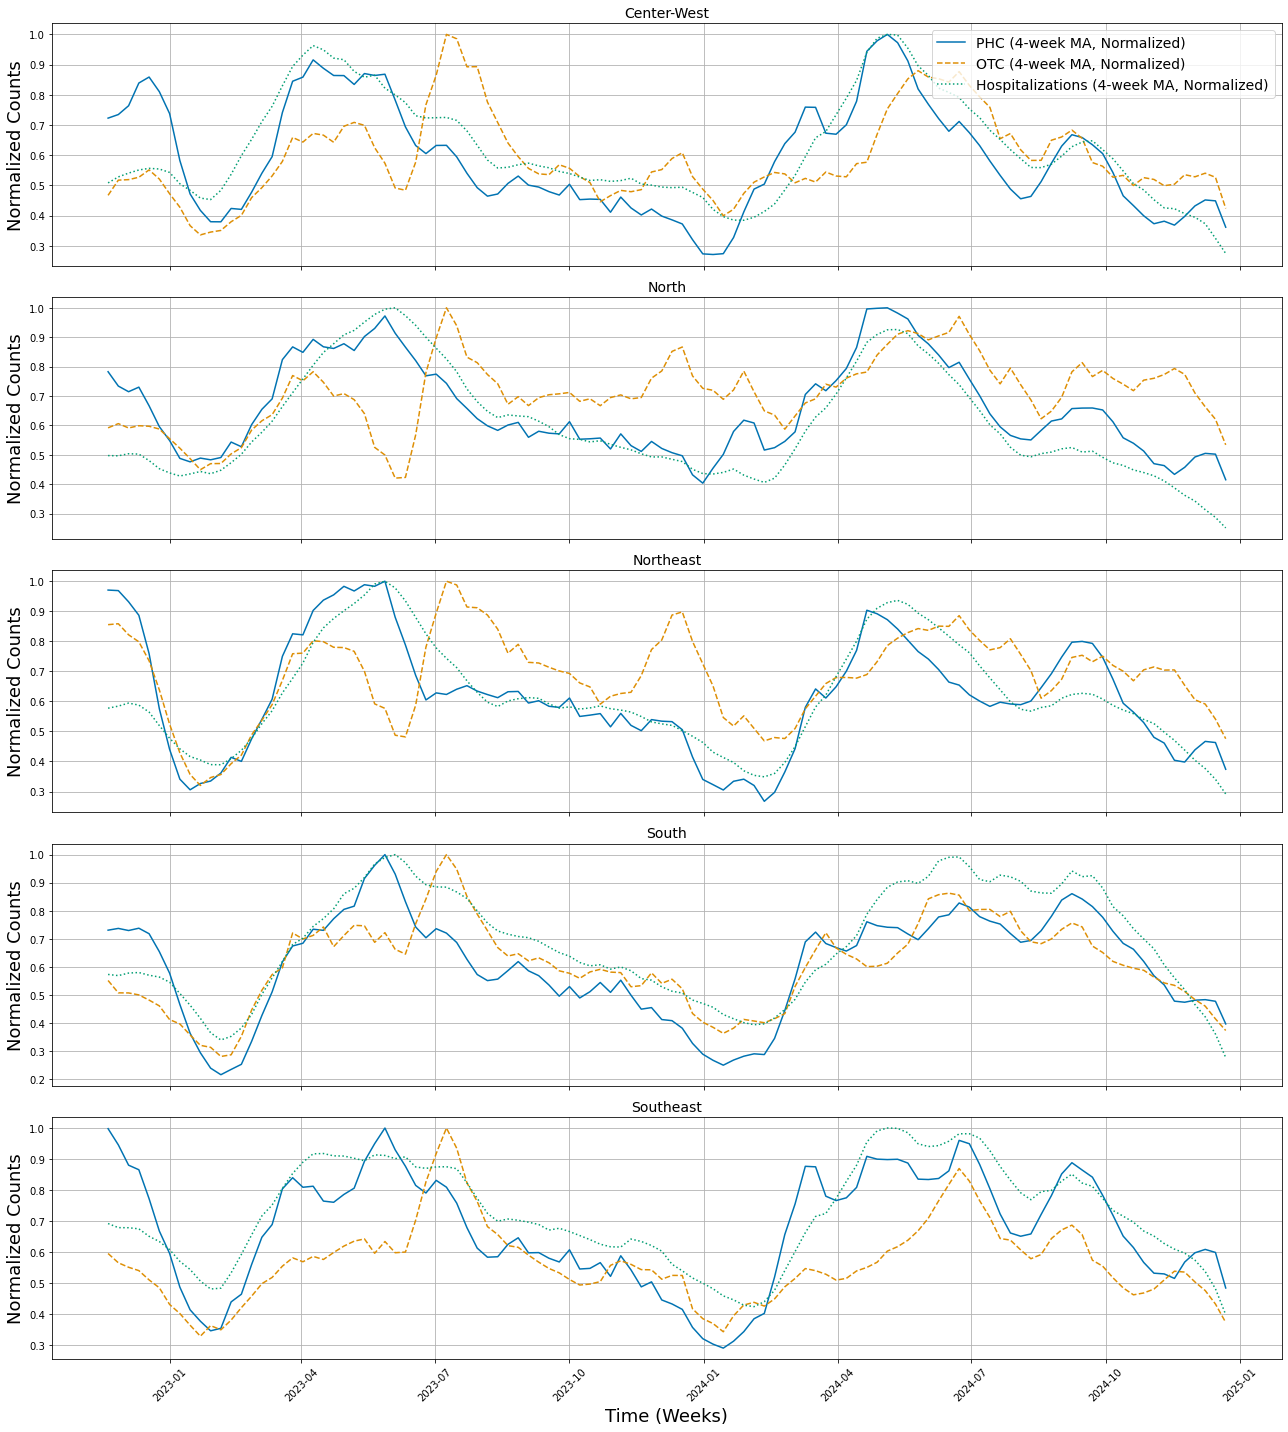

In [62]:
# Set color palette
sns.set_palette("colorblind")
colors = sns.color_palette("colorblind", 3)  # Extract 3 colors

# Get unique regions
regions = dta_br.region.unique()
num_regions = len(regions)

# Create figure with subplots
fig, axes = plt.subplots(nrows=num_regions, ncols=1, figsize=(18, 4 * num_regions), sharex=True)

# Ensure axes is iterable even if there's only one region
if num_regions == 1:
    axes = [axes]

# Loop through regions and plot in corresponding subplot
for ax, value in zip(axes, regions):
    
    df = dta_br[dta_br.region == value].copy()  # Make a copy to avoid modifying original data
    df = df.sort_values('year_week')

    # Convert 'epidemi_cal_start' to datetime
    df['epidemi_cal_start'] = pd.to_datetime(df['epidemi_cal_start'], errors='coerce')
    
    # Compute 4-week moving average
    df['phc_ma'] = df['atend_ivas'].astype(int).rolling(window=4, min_periods=1).mean()
    df['otc_ma'] = df['num_otc_ivas'].rolling(window=4, min_periods=1).mean()
    df['aih_ma'] = df['n'].rolling(window=4, min_periods=1).mean()
    
    # Normalize after smoothing
    df['phc_norm'] = df['phc_ma'] / df['phc_ma'].max()
    df['otc_norm'] = df['otc_ma'] / df['otc_ma'].max()
    df['aih_norm'] = df['aih_ma'] / df['aih_ma'].max()
    
    # Plotting
    ax.plot(df['epidemi_cal_start'], df['phc_norm'], label="PHC (4-week MA, Normalized)", linestyle="-", color=colors[0])
    ax.plot(df['epidemi_cal_start'], df['otc_norm'], label="OTC (4-week MA, Normalized)", linestyle="--", color=colors[1])
    ax.plot(df['epidemi_cal_start'], df['aih_norm'], label="Hospitalizations (4-week MA, Normalized)", linestyle=":", color=colors[2])
    
    # Formatting
    ax.set_ylabel("Normalized Counts", fontsize=18)
    ax.set_title(value, fontsize=14)
    ax.grid(True)

# Global formatting
axes[-1].set_xlabel("Time (Weeks)", fontsize=18)
axes[0].legend(fontsize=14, loc='upper right')
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Save the figure before displaying it
plt.savefig("regional_trends.png", dpi=300, bbox_inches="tight")  # Saves as high-quality PNG

plt.show()


Temporal trends of influenza-like illness indicators across Brazilian regions. 
Each subplot represents a different region, showing the normalized 4-week moving average of 
PHC encounters (solid line), over-the-counter drug sales (dashed line), and hospitalizations (dotted line) 
from November 2022 to December 2024. 

Center-West


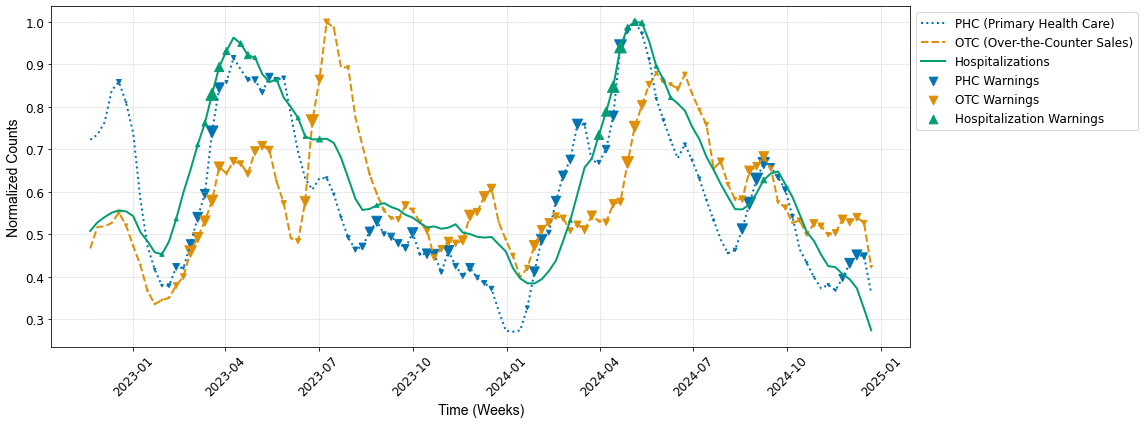

North


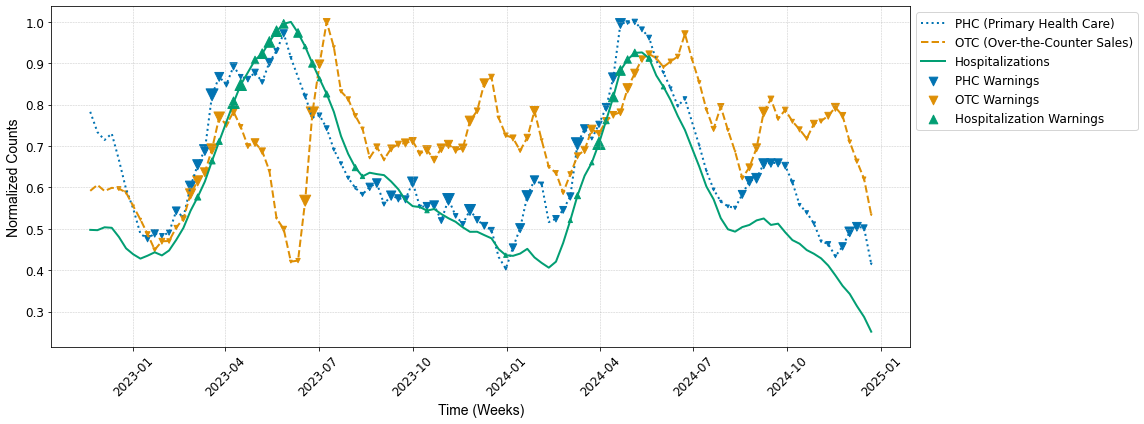

Northeast


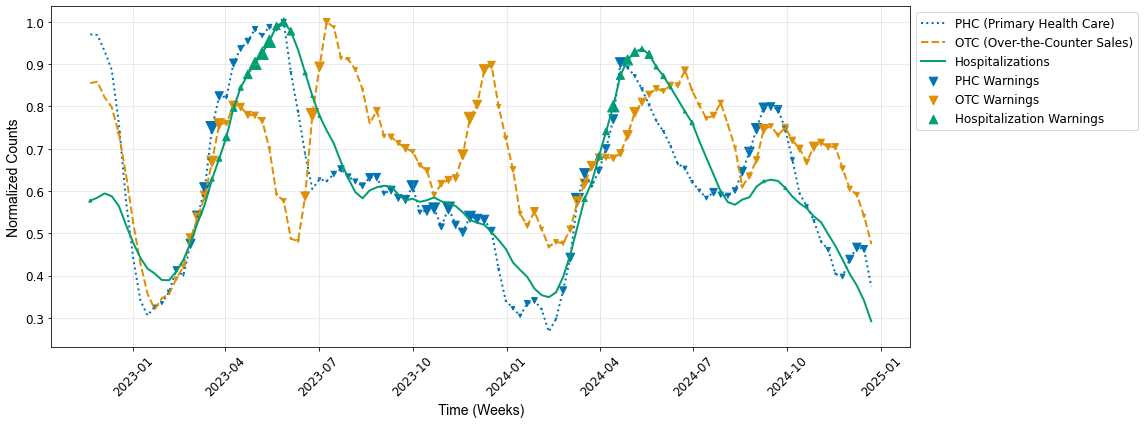

South


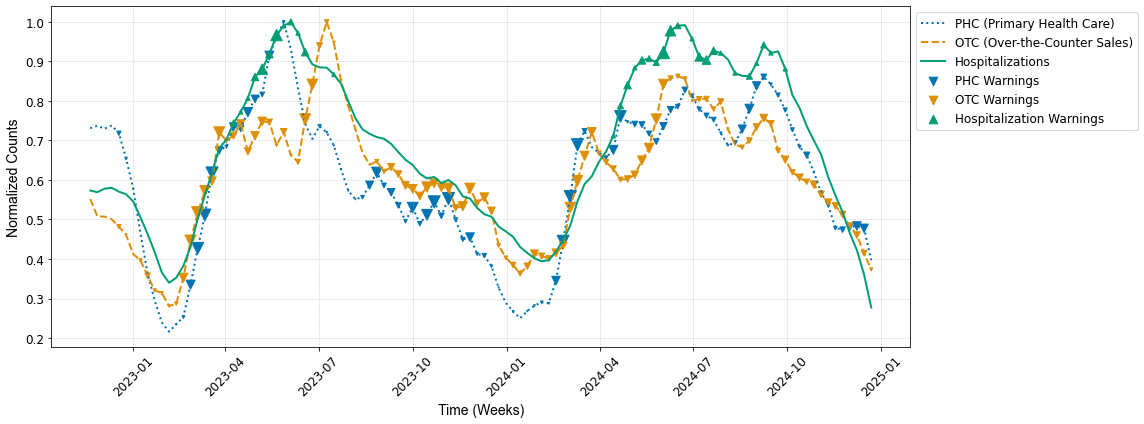

Southeast


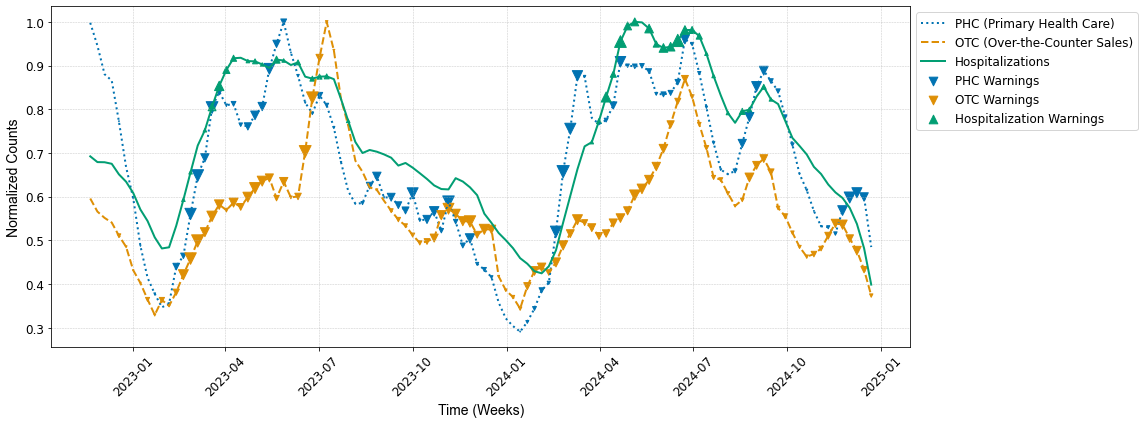

In [52]:
sns.set_palette("colorblind")

colors = sns.color_palette("colorblind", 3)  # Extract 3 colors

for value in dta_br.region.unique():
    
    print(value)

    df = dta_br[dta_br.region == value]  # Make a copy to avoid modifying original data
    
    df = df.sort_values('year_week')

        # Ensure 'epidemi_cal_start' is in datetime format
    df['epidemi_cal_start'] = pd.to_datetime(df['epidemi_cal_start'])
    
    # Compute 4-week moving average
    df['phc_ma'] = df['atend_ivas'].astype(int).rolling(window=4, min_periods=1).mean()
    df['otc_ma'] = df['num_otc_ivas'].rolling(window=4, min_periods=1).mean()
    df['aih_ma'] = df['n'].rolling(window=4, min_periods=1).mean()
    
    # Normalize after smoothing
    df['phc_norm'] = df['phc_ma'] / df['phc_ma'].max()
    df['otc_norm'] = df['otc_ma'] / df['otc_ma'].max()
    df['aih_norm'] = df['aih_ma'] / df['aih_ma'].max()
    
    # Compute normalized warning columns (scaling between 0 and 1)
    df['warnings_phc_norm'] = df['out_of_limits_above_phc_only'] / df['out_of_limits_above_phc_only'].max()
    df['warnings_otc_norm'] = df['out_of_limits_above_otc_only'] / df['out_of_limits_above_otc_only'].max()
    df['warnings_aih_norm'] = df['warning_final_aih'] / df['warning_final_aih'].max()
    
    # Define triangle size scaling (adjust as needed for visibility)
    triangle_size_phc = df['warnings_phc_norm'] * 150  
    triangle_size_otc = df['warnings_otc_norm'] * 150  
    triangle_size_aih = df['warnings_aih_norm'] * 150  
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot PHC, OTC, and AIH normalized time series
    ax.plot(df['epidemi_cal_start'], df['phc_norm'], label="PHC (Primary Health Care)", linestyle=":", 
            color=colors[0], linewidth=2) #alpha=0.5

    ax.plot(df['epidemi_cal_start'], df['otc_norm'], label="OTC (Over-the-Counter Sales)", linestyle="--", 
            color=colors[1], linewidth=2)
    
    ax.plot(df['epidemi_cal_start'], df['aih_norm'], label="Hospitalizations", linestyle="-", 
            color=colors[2], linewidth=2)

    # Add PHC warning triangles
    ax.scatter(df['epidemi_cal_start'], df['phc_norm'], 
               marker='v', color=colors[0],s=triangle_size_phc, label="PHC Warnings")

    # Add OTC warning triangles
    ax.scatter(df['epidemi_cal_start'], df['otc_norm'], 
               marker='v', color=colors[1],s=triangle_size_otc, label="OTC Warnings")

    # Add AIH warning triangles
    ax.scatter(df['epidemi_cal_start'], df['aih_norm'], 
               marker='^', color=colors[2], s=triangle_size_aih, label="Hospitalization Warnings")

    # Formatting  
    ax.set_xlabel("Time (Weeks)", fontsize=14, fontname="Arial")  
    ax.set_ylabel("Normalized Counts", fontsize=14, fontname="Arial")  
    #ax.set_title("Time Series of PHC, OTC & Hospitalizations with Warning Indicators", fontsize=18, fontweight="bold", fontname="Arial")  

    ax.tick_params(axis='both', labelsize=12)  
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  

    # Rotate x-axis labels for better readability  
    plt.xticks(rotation=45)  

    # Move the legend outside the plot  
    ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))  

    # Adjust layout for better spacing  
    plt.tight_layout()  

    # Show the plot  
    plt.show()


# Test trend

In [64]:
# Create an empty list to store results
results = []

# Loop through each region
for value in dta_br.region.unique():
    
    df = dta_br[dta_br.region == value].copy()  # Make a copy to avoid modifying original data
    df = df.sort_values('year_week')

    # Compute 4-week moving average
    df['phc_ma'] = df['atend_ivas'].astype(int).rolling(window=4, min_periods=1).mean()
    df['otc_ma'] = df['num_otc_ivas'].rolling(window=4, min_periods=1).mean()
    df['aih_ma'] = df['n'].rolling(window=4, min_periods=1).mean()

    # Perform Mann-Kendall tests
    mk_phc = mk.original_test(df['phc_ma'])
    mk_otc = mk.original_test(df['otc_ma'])
    mk_aih = mk.original_test(df['aih_ma'])

    # Store results in a list
    results.append({
        "Region": value,
        "PHC Trend": mk_phc.trend,
        "PHC p-value": mk_phc.p,
        "OTC Trend": mk_otc.trend,
        "OTC p-value": mk_otc.p,
        "Hospitalizations Trend": mk_aih.trend,
        "Hospitalizations p-value": mk_aih.p
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the table
#print(results_df)

# Optionally, save it to a CSV file
#results_df.to_csv("mann_kendall_results.csv", index=False)


In [65]:
results_df

,Region,PHC Trend,PHC p-value,OTC Trend,OTC p-value,Hospitalizations Trend,Hospitalizations p-value
0,Center-West,decreasing,0.003943,no trend,9.315350e-02,decreasing,0.012587
1,North,decreasing,0.018485,increasing,8.070498e-07,decreasing,0.001372
2,Northeast,decreasing,0.044471,no trend,6.531046e-01,no trend,0.116298
3,South,no trend,0.396858,no trend,1.630595e-01,no trend,0.113916
4,Southeast,no trend,0.686979,no trend,5.117607e-01,no trend,0.760517


In [71]:
lst_dfs = []

# Loop through each region
for value in dta_br.region.unique():
    
    df = dta_br[dta_br.region == value].copy()  # Make a copy to avoid modifying original data
    df = df.sort_values('year_week')

    # Compute 4-week moving average
    df['phc_ma'] = df['atend_ivas'].astype(int).rolling(window=4, min_periods=1).mean()
    df['otc_ma'] = df['num_otc_ivas'].rolling(window=4, min_periods=1).mean()
    df['aih_ma'] = df['n'].rolling(window=4, min_periods=1).mean()

    # Append the DataFrame to the list
    lst_dfs.append(df)

### Run negative binomial regressions to identify trend

In [86]:
# Function to handle Negative Binomial regression
def fit_negative_binomial(series_name):
    if dta[series_name].isnull().all() or np.all(dta[series_name] == 0):
        
        return {
                f'coef_negbi_{series_name}': 0,
                f'std_err_negbi_{series_name}': 0,
                f'z_negbi_{series_name}': 0,
                f'p_values_negbi_{series_name}': 1,
                f'IC_low_negbi_{series_name}': 0,
                f'IC_high_negbi_{series_name}': 0,
                f'trend_line_negbi_{series_name}': np.zeros(len(dta))
                }
    
    else:
        model = smf.glm(
                formula=f'{series_name} ~ time_trend',
                data=dta,
                family=sm.families.NegativeBinomial(alpha=1)
                ).fit()
            
        return {
                f'coef_negbi_{series_name}': model.params['time_trend'],
                f'std_err_negbi_{series_name}': model.bse['time_trend'],
                f'z_negbi_{series_name}': model.tvalues['time_trend'],
                f'p_values_negbi_{series_name}': model.pvalues['time_trend'],
                f'IC_low_negbi_{series_name}': model.conf_int().loc['time_trend', 0],
                f'IC_high_negbi_{series_name}': model.conf_int().loc['time_trend', 1],
                f'trend_line_negbi_{series_name}': model.predict()
                }

lst_results = []  # Initialize an empty list to store the processed DataFrames

for dta in lst_dfs:
    # Add a time trend column
    dta = dta.assign(time_trend=np.arange(len(dta)))

    # Fit Negative Binomial regression and update DataFrame
    negbi_serie = fit_negative_binomial('phc_ma')
        

    dta = dta.assign(**negbi_serie)

    # Append the processed DataFrame to the list
    lst_results.append(dta)


res =  pd.concat(lst_results, ignore_index=True)

print('Number of regions with significant trend')
res[res.p_values_negbi_phc_ma <= 0.05].region.nunique()

Number of regions with significant trend


0

In [88]:
# Function to handle Negative Binomial regression
def fit_negative_binomial(series_name):
    if dta[series_name].isnull().all() or np.all(dta[series_name] == 0):
        
        return {
                f'coef_negbi_{series_name}': 0,
                f'std_err_negbi_{series_name}': 0,
                f'z_negbi_{series_name}': 0,
                f'p_values_negbi_{series_name}': 1,
                f'IC_low_negbi_{series_name}': 0,
                f'IC_high_negbi_{series_name}': 0,
                f'trend_line_negbi_{series_name}': np.zeros(len(dta))
                }
    
    else:
        model = smf.glm(
                formula=f'{series_name} ~ time_trend',
                data=dta,
                family=sm.families.NegativeBinomial(alpha=1)
                ).fit()
            
        return {
                f'coef_negbi_{series_name}': model.params['time_trend'],
                f'std_err_negbi_{series_name}': model.bse['time_trend'],
                f'z_negbi_{series_name}': model.tvalues['time_trend'],
                f'p_values_negbi_{series_name}': model.pvalues['time_trend'],
                f'IC_low_negbi_{series_name}': model.conf_int().loc['time_trend', 0],
                f'IC_high_negbi_{series_name}': model.conf_int().loc['time_trend', 1],
                f'trend_line_negbi_{series_name}': model.predict()
                }

lst_results = []  # Initialize an empty list to store the processed DataFrames

for dta in lst_dfs:
    # Add a time trend column
    dta = dta.assign(time_trend=np.arange(len(dta)))

    # Fit Negative Binomial regression and update DataFrame
    negbi_serie = fit_negative_binomial('otc_ma')
        

    dta = dta.assign(**negbi_serie)

    # Append the processed DataFrame to the list
    lst_results.append(dta)


res =  pd.concat(lst_results, ignore_index=True)

print('Number of regions with significant trend')
res[res.p_values_negbi_otc_ma <= 0.05].region.nunique()


Number of regions with significant trend


0

In [91]:
# Function to handle Negative Binomial regression
def fit_negative_binomial(series_name):
    if dta[series_name].isnull().all() or np.all(dta[series_name] == 0):
        
        return {
                f'coef_negbi_{series_name}': 0,
                f'std_err_negbi_{series_name}': 0,
                f'z_negbi_{series_name}': 0,
                f'p_values_negbi_{series_name}': 1,
                f'IC_low_negbi_{series_name}': 0,
                f'IC_high_negbi_{series_name}': 0,
                f'trend_line_negbi_{series_name}': np.zeros(len(dta))
                }
    
    else:
        model = smf.glm(
                formula=f'{series_name} ~ time_trend',
                data=dta,
                family=sm.families.NegativeBinomial(alpha=1)
                ).fit()
            
        return {
                f'coef_negbi_{series_name}': model.params['time_trend'],
                f'std_err_negbi_{series_name}': model.bse['time_trend'],
                f'z_negbi_{series_name}': model.tvalues['time_trend'],
                f'p_values_negbi_{series_name}': model.pvalues['time_trend'],
                f'IC_low_negbi_{series_name}': model.conf_int().loc['time_trend', 0],
                f'IC_high_negbi_{series_name}': model.conf_int().loc['time_trend', 1],
                f'trend_line_negbi_{series_name}': model.predict()
                }

lst_results = []  # Initialize an empty list to store the processed DataFrames

for dta in lst_dfs:
    # Add a time trend column
    dta = dta.assign(time_trend=np.arange(len(dta)))

    # Fit Negative Binomial regression and update DataFrame
    negbi_serie = fit_negative_binomial('aih_ma')
        

    dta = dta.assign(**negbi_serie)

    # Append the processed DataFrame to the list
    lst_results.append(dta)


res =  pd.concat(lst_results, ignore_index=True)

print('Number of regions with significant trend')
res[res.p_values_negbi_aih_ma <= 0.05].region.nunique()


Number of regions with significant trend


0

In [92]:
# Create an empty list to store results
seasonality_results = []

# Loop through each region
for value in dta_br.region.unique():
    
    df = dta_br[dta_br.region == value].copy()  # Make a copy to avoid modifying original data
    df = df.sort_values('year_week')

    # Compute 4-week moving average
    df['phc_ma'] = df['atend_ivas'].astype(int).rolling(window=4, min_periods=1).mean()
    df['otc_ma'] = df['num_otc_ivas'].rolling(window=4, min_periods=1).mean()
    df['aih_ma'] = df['n'].rolling(window=4, min_periods=1).mean()

    # Define seasonal period (half the dataset length)
    p = len(df) // 2  

    # Perform Friedman test
    try:
        friedman_phc = friedmanchisquare(*[df['phc_ma'].to_numpy()[i::p] for i in range(p)])
        friedman_otc = friedmanchisquare(*[df['otc_ma'].to_numpy()[i::p] for i in range(p)])
        friedman_aih = friedmanchisquare(*[df['aih_ma'].to_numpy()[i::p] for i in range(p)])

        # Store results with significance check
        seasonality_results.append({
            "Region": value,
            "PHC p-value": friedman_phc.pvalue,
            "PHC Seasonality": "Yes" if friedman_phc.pvalue < 0.05 else "No",
            "OTC p-value": friedman_otc.pvalue,
            "OTC Seasonality": "Yes" if friedman_otc.pvalue < 0.05 else "No",
            "Hospitalizations p-value": friedman_aih.pvalue,
            "Hospitalizations Seasonality": "Yes" if friedman_aih.pvalue < 0.05 else "No"
        })
    
    except ValueError:
        print(f"Not enough data for seasonality test in {value}")
        continue

# Convert results to a DataFrame
seasonality_df = pd.DataFrame(seasonality_results)

# Display the table
#print(seasonality_df)

# Optionally, save it to a CSV file
#seasonality_df.to_csv("friedman_seasonality_results.csv", index=False)


In [93]:
seasonality_df

,Region,PHC p-value,PHC Seasonality,OTC p-value,OTC Seasonality,Hospitalizations p-value,Hospitalizations Seasonality
0,Center-West,0.040169,Yes,0.003608,Yes,0.000051,Yes
1,North,0.003117,Yes,0.569623,No,0.000371,Yes
2,Northeast,0.002977,Yes,0.029271,Yes,0.000142,Yes
3,South,0.021533,Yes,0.000344,Yes,0.000064,Yes
4,Southeast,0.045121,Yes,0.000238,Yes,0.000064,Yes


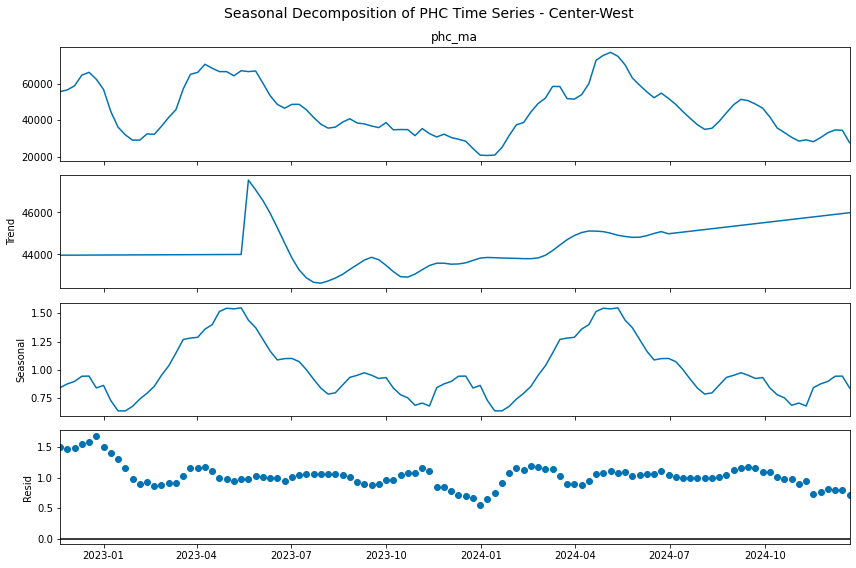

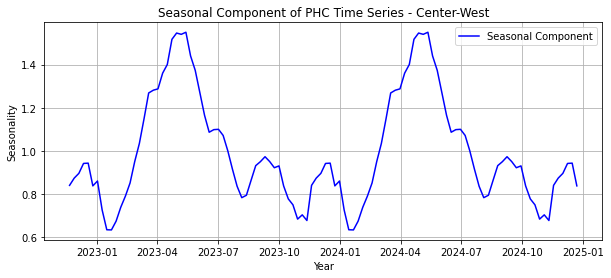

Peak Seasonality for Center-West:
epidemi_cal_start
2023-05-14    1.549465
2024-05-12    1.549465
Name: seasonal, dtype: float64

Summary of Seasonal Component for Center-West:
 count    110.000000
mean       0.993924
std        0.253239
min        0.633617
25%        0.836218
50%        0.931371
75%        1.136207
max        1.549465
Name: seasonal, dtype: float64

Periods of High Seasonality (> 0.931) for Center-West:
  epidemi_cal_start  seasonal
0        2022-12-11  0.941605
1        2022-12-18  0.943008
2        2023-02-26  0.950222
3        2023-03-05  1.034309
4        2023-03-12  1.148364


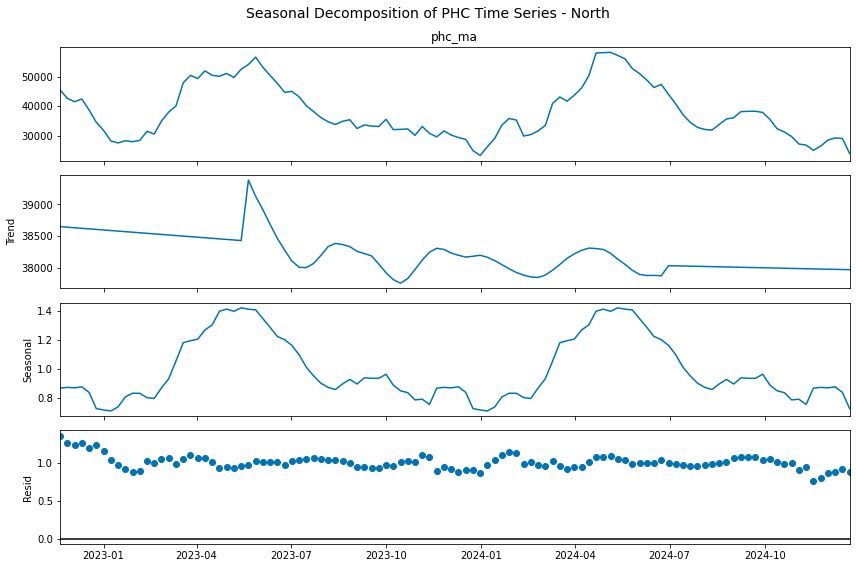

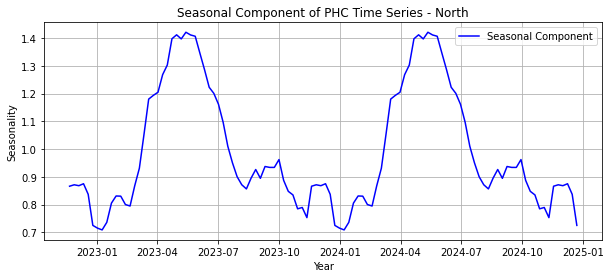

Peak Seasonality for North:
epidemi_cal_start
2023-05-14    1.421147
2024-05-12    1.421147
Name: seasonal, dtype: float64

Summary of Seasonal Component for North:
 count    110.000000
mean       0.991303
std        0.218152
min        0.708792
25%        0.837189
50%        0.895234
75%        1.190293
max        1.421147
Name: seasonal, dtype: float64

Periods of High Seasonality (> 0.895) for North:
  epidemi_cal_start  seasonal
0        2023-03-05  0.931191
1        2023-03-12  1.053789
2        2023-03-19  1.180192
3        2023-03-26  1.193661
4        2023-04-02  1.204850


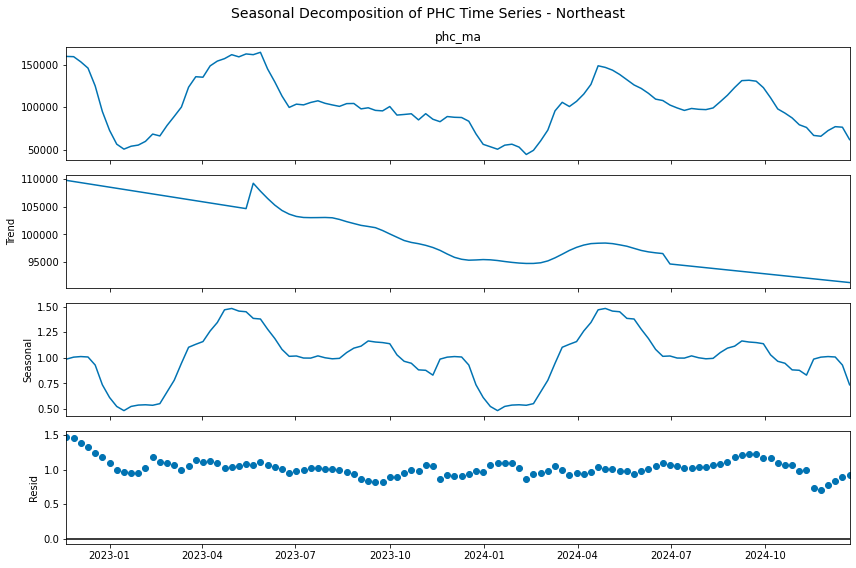

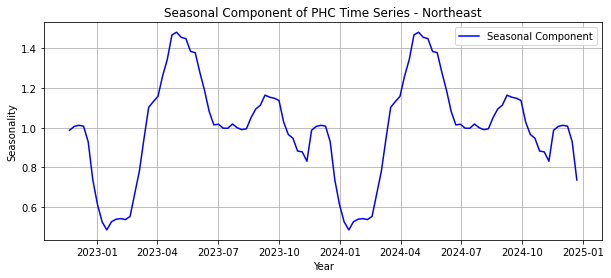

Peak Seasonality for Northeast:
epidemi_cal_start
2023-04-30    1.481559
2024-04-28    1.481559
Name: seasonal, dtype: float64

Summary of Seasonal Component for Northeast:
 count    110.000000
mean       0.997103
std        0.259315
min        0.485172
25%        0.882675
50%        1.008165
75%        1.145987
max        1.481559
Name: seasonal, dtype: float64

Periods of High Seasonality (> 1.008) for Northeast:
  epidemi_cal_start  seasonal
0        2022-12-04  1.012371
1        2023-03-19  1.102939
2        2023-03-26  1.132125
3        2023-04-02  1.158605
4        2023-04-09  1.261958


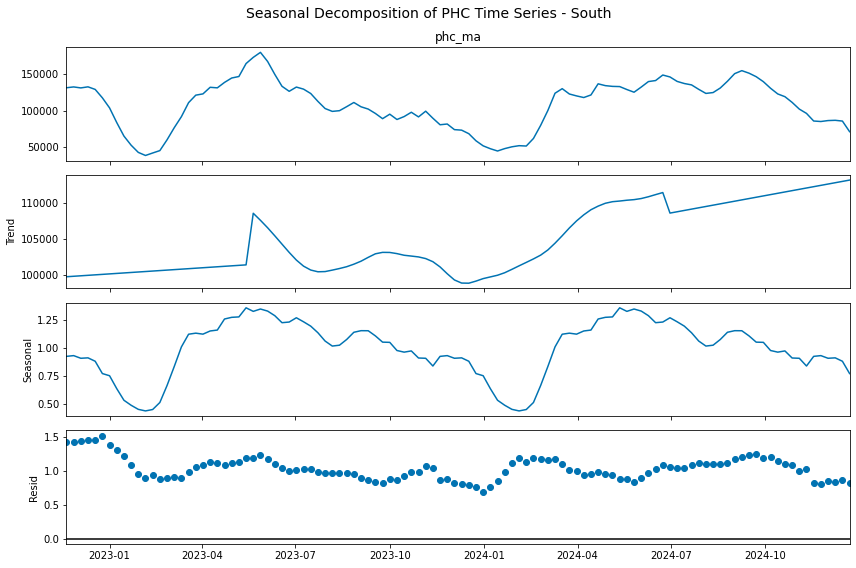

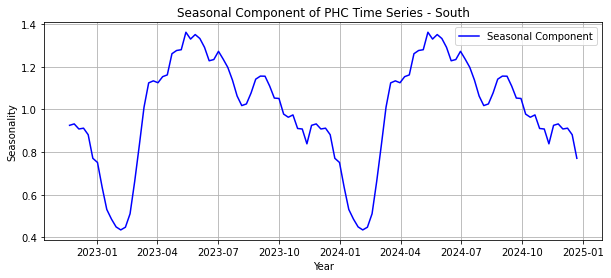

Peak Seasonality for South:
epidemi_cal_start
2023-05-14    1.362318
2024-05-12    1.362318
Name: seasonal, dtype: float64

Summary of Seasonal Component for South:
 count    110.000000
mean       0.993908
std        0.251535
min        0.434530
25%        0.888075
50%        1.025812
75%        1.160664
max        1.362318
Name: seasonal, dtype: float64

Periods of High Seasonality (> 1.026) for South:
  epidemi_cal_start  seasonal
0        2023-03-19  1.124695
1        2023-03-26  1.134142
2        2023-04-02  1.125319
3        2023-04-09  1.153826
4        2023-04-16  1.162066


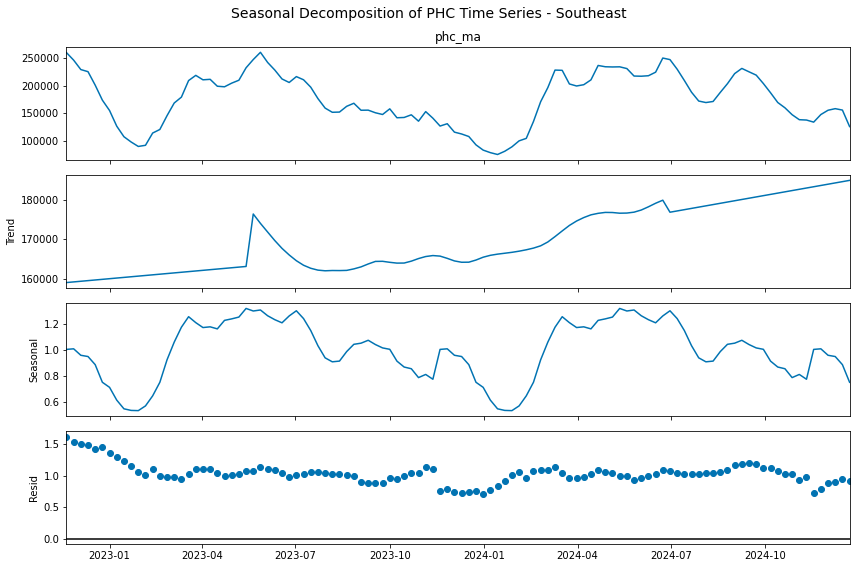

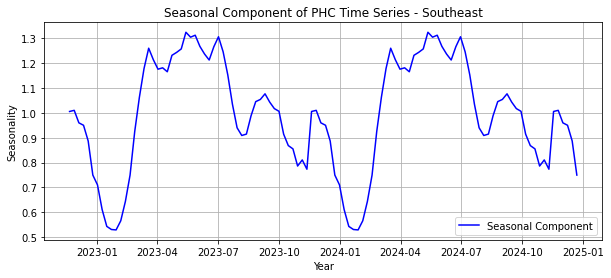

Peak Seasonality for Southeast:
epidemi_cal_start
2023-05-14    1.324188
2024-05-12    1.324188
Name: seasonal, dtype: float64

Summary of Seasonal Component for Southeast:
 count    110.000000
mean       0.996016
std        0.224011
min        0.529088
25%        0.868316
50%        1.008137
75%        1.204609
max        1.324188
Name: seasonal, dtype: float64

Periods of High Seasonality (> 1.008) for Southeast:
  epidemi_cal_start  seasonal
0        2022-11-27  1.010077
1        2023-03-05  1.062229
2        2023-03-12  1.178059
3        2023-03-19  1.259952
4        2023-03-26  1.213722


In [106]:
# Dictionary to store decomposition results for each region
decomposition_results = {}

for i, df in enumerate(lst_dfs):  
    region_name = df['region'].iloc[0]  # Assuming 'region' column exists

    # Ensure datetime format and set as index
    df['epidemi_cal_start'] = pd.to_datetime(df['epidemi_cal_start'])
    df = df.set_index('epidemi_cal_start').asfreq('W')  # Set to weekly frequency

    # Seasonal Decomposition
    result = sm.tsa.seasonal_decompose(df['phc_ma'], model='multiplicative', period=52, extrapolate_trend='freq')
    decomposition_results[region_name] = result  # Store results

    # Plot full decomposition
    fig = result.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle(f'Seasonal Decomposition of PHC Time Series - {region_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot only the seasonal component
    plt.figure(figsize=(10, 4))
    plt.plot(result.seasonal, label='Seasonal Component', color='b')
    plt.title(f'Seasonal Component of PHC Time Series - {region_name}', fontsize=12)
    plt.xlabel('Year')
    plt.ylabel('Seasonality')
    plt.legend()
    plt.grid()
    plt.show()

    # Identify peak of seasonality
    peak_seasonality = result.seasonal[result.seasonal == result.seasonal.max()]
    print(f"Peak Seasonality for {region_name}:")
    print(peak_seasonality)

    # Summary statistics of the seasonal component
    seasonality_stats = result.seasonal.describe()
    print(f"\nSummary of Seasonal Component for {region_name}:\n", seasonality_stats)

    # Find periods where seasonality exceeds the 50% quantile threshold
    threshold = seasonality_stats['50%']
    high_season_periods = result.seasonal[result.seasonal > threshold].reset_index()
    
    # Group and summarize
    seasonality_summary = high_season_periods.groupby('epidemi_cal_start')['seasonal'].sum().reset_index()
    
    print(f"\nPeriods of High Seasonality (> {threshold:.3f}) for {region_name}:")
    print(seasonality_summary.head())  # Display only first few rows


In [ ]:
Peak Seasonality for Center-West:
epidemi_cal_start
2023-05-14    1.549465
2024-05-12    1.549465

Peak Seasonality for North:
epidemi_cal_start
2023-05-14    1.421147
2024-05-12    1.421147

Peak Seasonality for Northeast:
epidemi_cal_start
2023-04-30    1.481559
2024-04-28    1.481559

Peak Seasonality for South:
epidemi_cal_start
2023-05-14    1.362318
2024-05-12    1.362318

Peak Seasonality for Southeast:
epidemi_cal_start
2023-05-14    1.324188
2024-05-12    1.324188


In [ ]:
Periods of High Seasonality (> 0.931) for Center-West:
  epidemi_cal_start  seasonal
2        2023-02-26  0.950222
3        2023-03-05  1.034309
4        2023-03-12  1.148364

Periods of High Seasonality (> 0.895) for North:
  epidemi_cal_start  seasonal
0        2023-03-05  0.931191
1        2023-03-12  1.053789
2        2023-03-19  1.180192
3        2023-03-26  1.193661
4        2023-04-02  1.204850

Periods of High Seasonality (> 1.008) for Northeast:
  epidemi_cal_start  seasonal
1        2023-03-19  1.102939
2        2023-03-26  1.132125
3        2023-04-02  1.158605
4        2023-04-09  1.261958

Periods of High Seasonality (> 1.026) for South:
  epidemi_cal_start  seasonal
0        2023-03-19  1.124695
1        2023-03-26  1.134142
2        2023-04-02  1.125319
3        2023-04-09  1.153826
4        2023-04-16  1.162066

Periods of High Seasonality (> 1.008) for Southeast:
  epidemi_cal_start  seasonal
1        2023-03-05  1.062229
2        2023-03-12  1.178059
3        2023-03-19  1.259952
4        2023-03-26  1.213722